<a href="https://colab.research.google.com/github/SheetalData/Semantic_Segmentation/blob/main/Scripts/Detectron2_Model_WithoutError.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install dependency

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.11.0+cu113 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
#pytorch version 1.10 and CUDA 11.1 is installed
#import torch
#import requests
#assert torch.__version__.startswith("1.9")

In [ ]:

#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_exjzp9x
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_exjzp9x


In [ ]:
#Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
!pip install pipreqs



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pipreqs 

In [ ]:
#Register Coco dataset
from detectron2.data.datasets import register_coco_instances


register_coco_instances("Data_Register_training",{}, "/content/drive/MyDrive/Data/Train/merged_cleaned.json", "/content/drive/MyDrive/results/Train")
register_coco_instances("Data_Register_valid",{},"/content/drive/MyDrive/Data/Valid/merged_cleaned.json", "/content/drive/MyDrive/results/Valid")

metadata = MetadataCatalog.get("Data_Register_training")
dataset_train = DatasetCatalog.get("Data_Register_training")
dataset_valid = DatasetCatalog.get("Data_Register_valid")

[12/13 16:06:25 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Data/Train/merged_cleaned.json takes 4.79 seconds.
WARNING [12/13 16:06:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 16:06:25 d2.data.datasets.coco]: Loaded 6975 images in COCO format from /content/drive/MyDrive/Data/Train/merged_cleaned.json
WARNING [12/13 16:06:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 16:06:27 d2.data.datasets.coco]: Loaded 2100 images in COCO format from /content/drive/MyDrive/Data/Valid/merged_cleaned.json


In [ ]:
for d in dataset_train:
    annos = [obj for obj in d['annotations'] if 'segmentation' in obj]
    d['annotations'] = annos

    for obj in d['annotations']:
        if 'segmentation' not in obj:
            print(f'{d["file_name"]} has an annotation with no segmentation field')
            #exclude.add(["file_name"])
  
for d in dataset_valid:
    annos = [obj for obj in d['annotations'] if 'segmentation' in obj]
    d['annotations'] = annos

    for obj in d['annotations']:
        if 'segmentation' not in obj:
            print(f'{d["file_name"]} has an annotation with no segmentation field')
            #exclude.add(["file_name"])


(427, 640, 3)


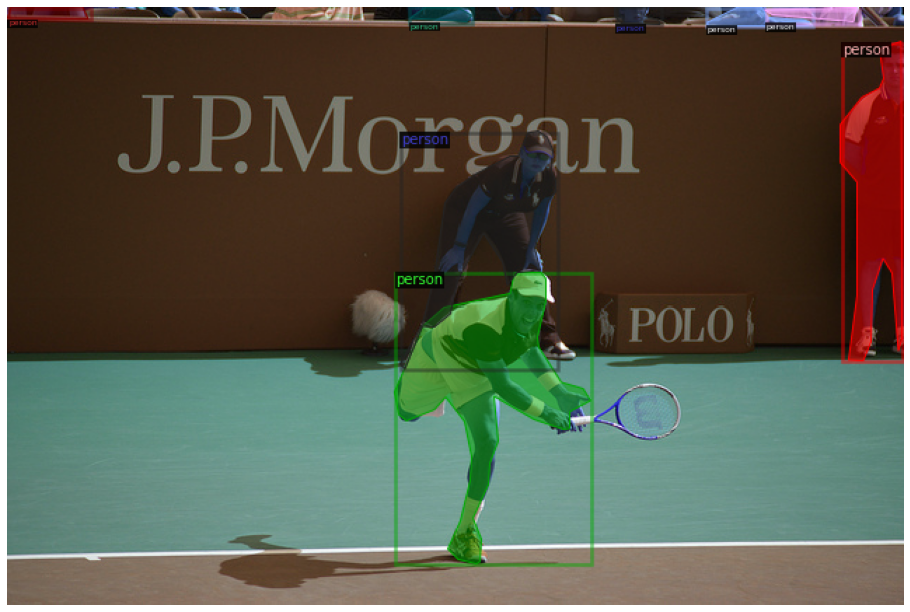

In [ ]:
fig, ax = plt.subplots(figsize =(18,11))
d=dataset_valid[4] 
img = cv2.imread(d["file_name"])
print(img.shape)
v = Visualizer(img[:, :, ::-1],
                metadata=metadata, 
                scale=1,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

In [ ]:
#Training
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("Data_Register_training",)
cfg.DATASETS.TEST = ("Data_Register_valid",)

#cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # 64 is slower but more accurate (128 faster but less accurate)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 148
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.SOLVER.BASE_LR = 0.0005 
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005
#cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 148
    
cfg.SOLVER.WARMUP_ITERS = 10 
cfg.SOLVER.MAX_ITER = 20000
cfg.SOLVER.STEPS = (500, 1000) 
cfg.TEST.EVAL_PERIOD = 250
cfg.SOLVER.CHECKPOINT_PERIOD=250

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) 
trainer = DefaultTrainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[12/13 16:20:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/13 16:21:03 d2.engine.train_loop]: Starting training from iteration 0
[12/13 16:21:09 d2.utils.events]:  eta: 1:02:55  iter: 19  total_loss: 5.795  loss_cls: 4.009  loss_box_reg: 0.8957  loss_mask: 0.6851  loss_rpn_cls: 0.07502  loss_rpn_loc: 0.03223  time: 0.2743  data_time: 0.1111  lr: 0.0005  max_mem: 3121M
[12/13 16:21:16 d2.utils.events]:  eta: 1:08:30  iter: 39  total_loss: 3.488  loss_cls: 1.509  loss_box_reg: 0.7479  loss_mask: 0.6275  loss_rpn_cls: 0.1902  loss_rpn_loc: 0.341  time: 0.3295  data_time: 0.1823  lr: 0.0005  max_mem: 3121M
[12/13 16:21:22 d2.utils.events]:  eta: 1:11:09  iter: 59  total_loss: 2.986  loss_cls: 1.304  loss_box_reg: 0.7111  loss_mask: 0.588  loss_rpn_cls: 0.1171  loss_rpn_loc: 0.3508  time: 0.3231  data_time: 0.1221  lr: 0.0005  max_mem: 3121M
[12/13 16:21:31 d2.utils.events]:  eta: 1:15:22  iter: 79  total_loss: 2.989  loss_cls: 1.219  loss_box_reg: 0.6377  loss_mask: 0.5811  loss_rpn_cls: 0.1445  loss_rpn_loc: 0.3079  time: 0.3516  data_time: 0

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}



In [ ]:
#Evaluation

In [ ]:
evaluator = COCOEvaluator("Data_Register_valid", cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="../input/detectron2cell/output/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, "Data_Register_valid")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/13 16:08:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/13 16:08:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 16:08:05 d2.data.datasets.coco]: Loaded 2100 images in COCO format from /content/drive/MyDrive/Data/Valid/merged_cleaned.json
[12/13 16:08:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/13 16:08:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/13 16:08:06 d2.data.common]: Serializing 2100 elements to byte tensors and concatenating them all ...
[12/13 16:08:07 d2.data.common]: Serialized dataset takes 11.52 MiB
[12/13 16:08:07 d2.evaluation.evaluator]: Start inference on 2100 batches
[12/13 16:08:08

OrderedDict([('bbox',
              {'AP': 0.5017368785381249,
               'AP50': 0.8264511275013678,
               'AP75': 0.5475567697188863,
               'APs': 0.5426065190693673,
               'APm': 0.6563637677100602,
               'APl': 0.9560619884950083,
               'AP-bench': 0.0,
               'AP-bicycle': 0.0,
               'AP-bus': 0.0,
               'AP-car': 30.595526757724915,
               'AP-motorcycle': 0.0,
               'AP-person': 19.07642421754945,
               'AP-stop sign': 0.0,
               'AP-traffic light': 0.0,
               'AP-train': 0.0,
               'AP-truck': 0.0,
               'AP-bicyclegroup': 0.0,
               'AP-bridge': 0.0,
               'AP-building': 0.0,
               'AP-caravan': 0.0,
               'AP-cargroup': 0.0,
               'AP-dynamic': 0.0,
               'AP-ego vehicle': 0.0,
               'AP-fence': 0.0,
               'AP-ground': 0.0,
               'AP-guard rail': 0.0,
          

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

In [ ]:
#Training Progress

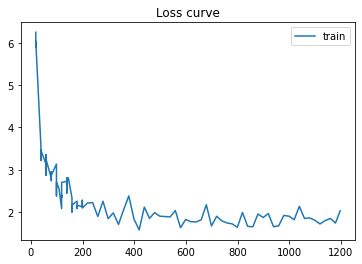

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

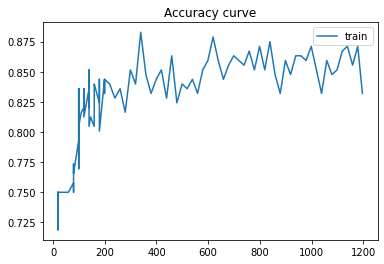

In [ ]:
# 2. Accuracy curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

In [ ]:
#Prediction

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("Data_Register_valid", )
predictor = DefaultPredictor(cfg)

[12/13 16:11:24 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

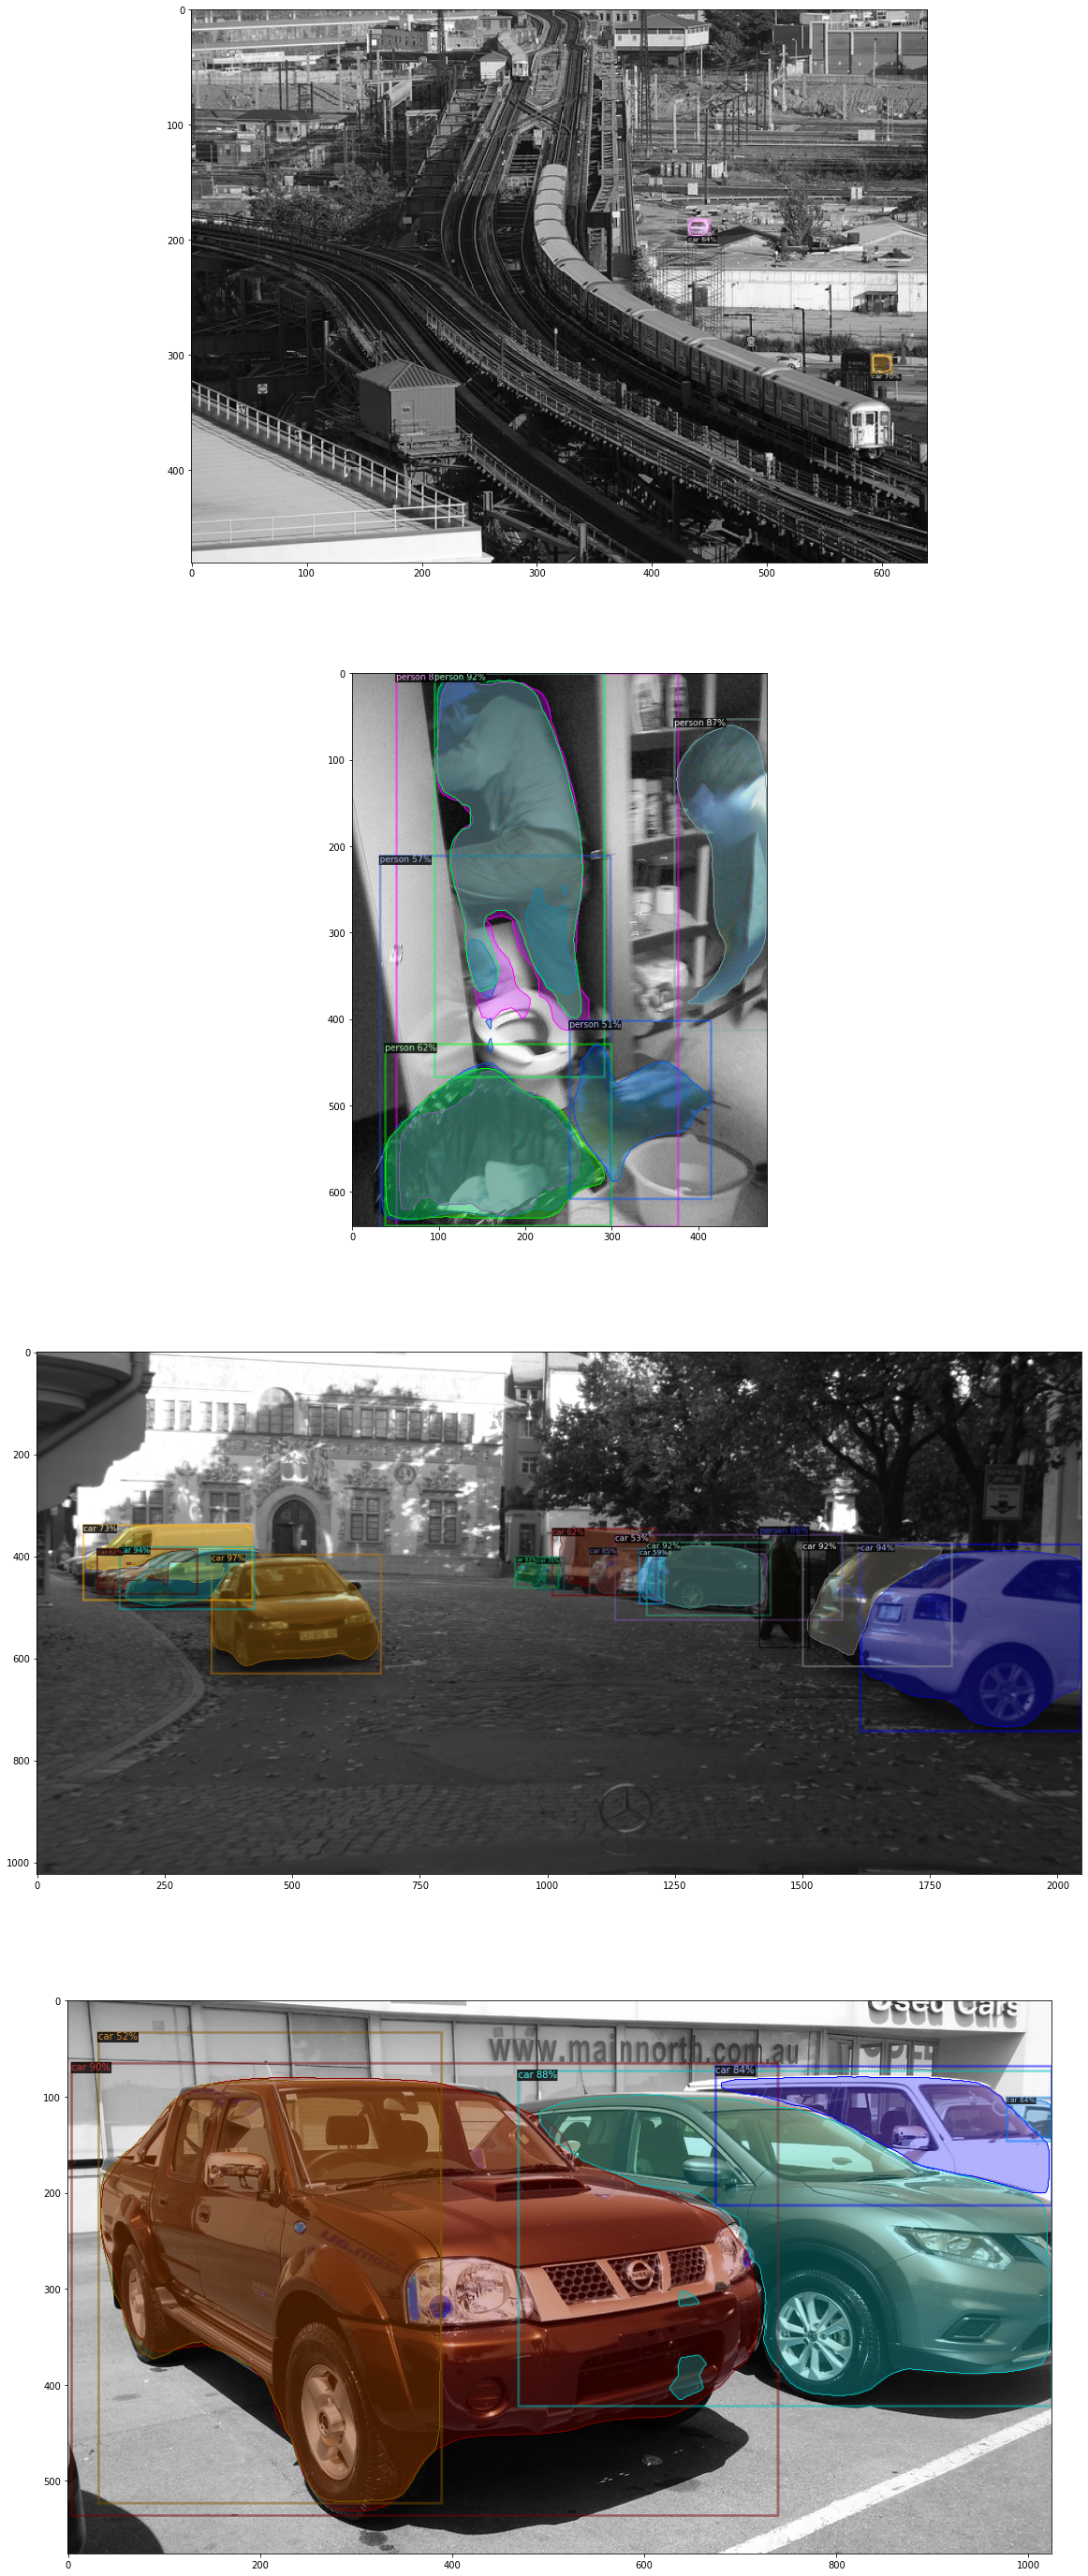

In [ ]:
fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_valid, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])